In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS =set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import re
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
df = pd.read_csv(r"amazon_alexa.tsv",delimiter='\t')
df.shape

(3150, 5)

In [68]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [165]:
data = df.copy()
print(df.iloc[3]['verified_reviews'])

I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.


In [70]:
df.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [8]:
df[df['verified_reviews'].isnull()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [71]:
df = df.dropna()

In [10]:
df.shape

(3149, 5)

In [11]:
df.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [12]:
df.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64


In [13]:
df['date'].value_counts()

,count
date,
30-Jul-18,1603
29-Jul-18,482
28-Jul-18,250
26-Jul-18,85
31-Jul-18,81
...,...
2-Jun-18,2
29-May-18,1
4-Jun-18,1


In [14]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [15]:
df['length'] = df['verified_reviews'].apply(len)
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [16]:
df['length'].max()
df[df['length']==1]

,rating,date,variation,verified_reviews,feedback,length
60,5,30-Jul-18,Heather Gray Fabric,😍,1,1
85,5,30-Jul-18,Heather Gray Fabric,,1,1
183,3,29-Jul-18,Heather Gray Fabric,,1,1
219,5,29-Jul-18,Sandstone Fabric,,1,1
374,1,26-Jul-18,Black,,0,1
...,...,...,...,...,...,...
3114,3,30-Jul-18,Black Dot,,1,1
3120,5,30-Jul-18,Black Dot,,1,1
3123,4,30-Jul-18,Black Dot,,1,1
3126,5,30-Jul-18,Black Dot,,1,1


In [17]:
tags = (df['rating'].value_counts()/df.shape[0])

<Axes: ylabel='count'>

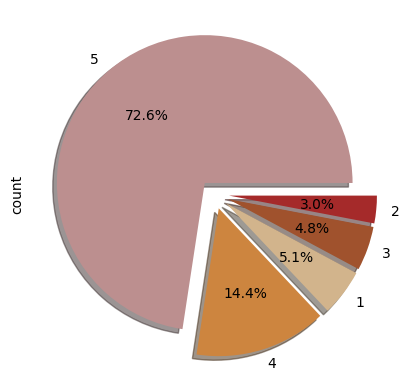

In [18]:
tags.plot(kind='pie',autopct='%1.1f%%',colors=['RosyBrown','Peru','Tan','Sienna','Brown'], explode = (0.1,0.1,0.1,0.1,0.1),shadow=True)

In [19]:
df[df['feedback']==1].iloc[1]['verified_reviews']    # first positive review of dataset

'Loved it!'

In [20]:
df[df['feedback']==0].iloc[1]['variation']  # first negative review of dataset

'Charcoal Fabric '

In [21]:
w = df['feedback'].value_counts()

Means 0 -> indicates negative feedbacks and 1 -> positive feedbacks


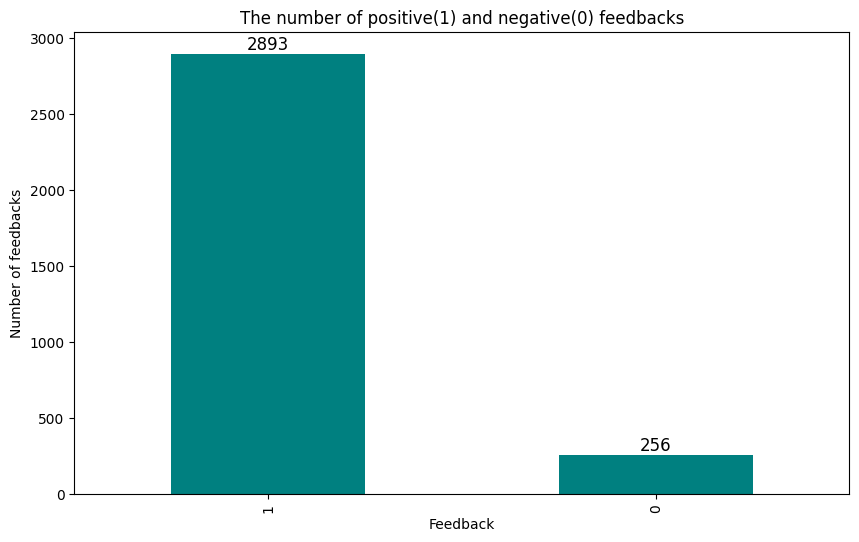

In [22]:
fig,ax = plt.subplots(figsize=(10,6))
ax = w.plot.bar(w.index ,  w.values,color='Teal')
plt.title('The number of positive(1) and negative(0) feedbacks')
plt.xlabel('Feedback')
plt.ylabel('Number of feedbacks')

for i, value in enumerate(w.values):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom',fontsize=12)

plt.show()


In [23]:
df[df['feedback']==1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


In [24]:
q = df['variation'].value_counts()

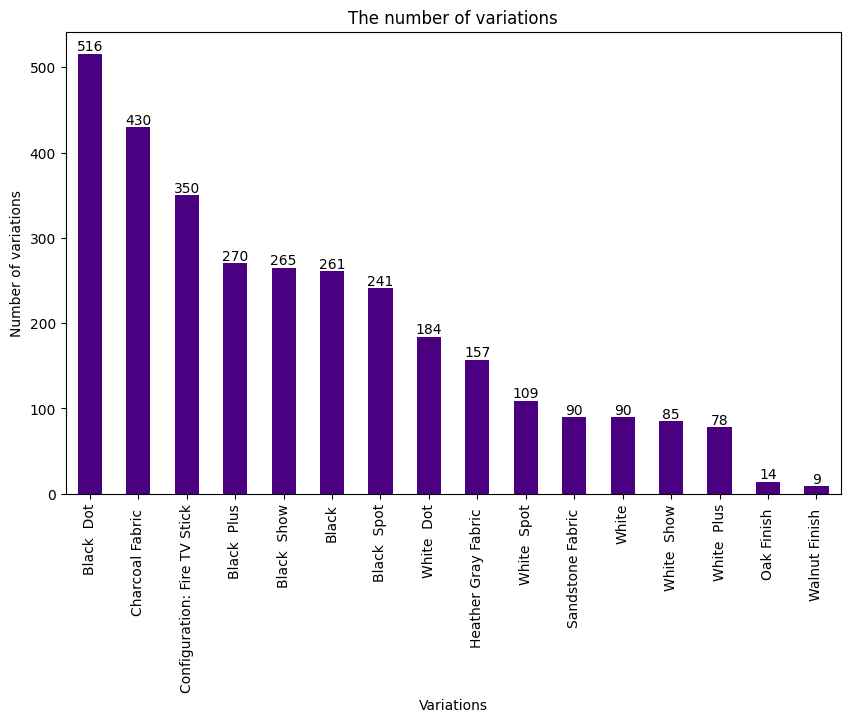

In [25]:
fig,ax = plt.subplots(figsize=(10,6))
ax = q.plot.bar(q.index,q.values,color='Indigo')
for i , value in enumerate(q.values):
  ax.text(i, value+0.1,str(value),ha='center',va='bottom',fontsize=10)

plt.title('The number of variations')
plt.xlabel('Variations')
plt.ylabel('Number of variations')
plt.show()


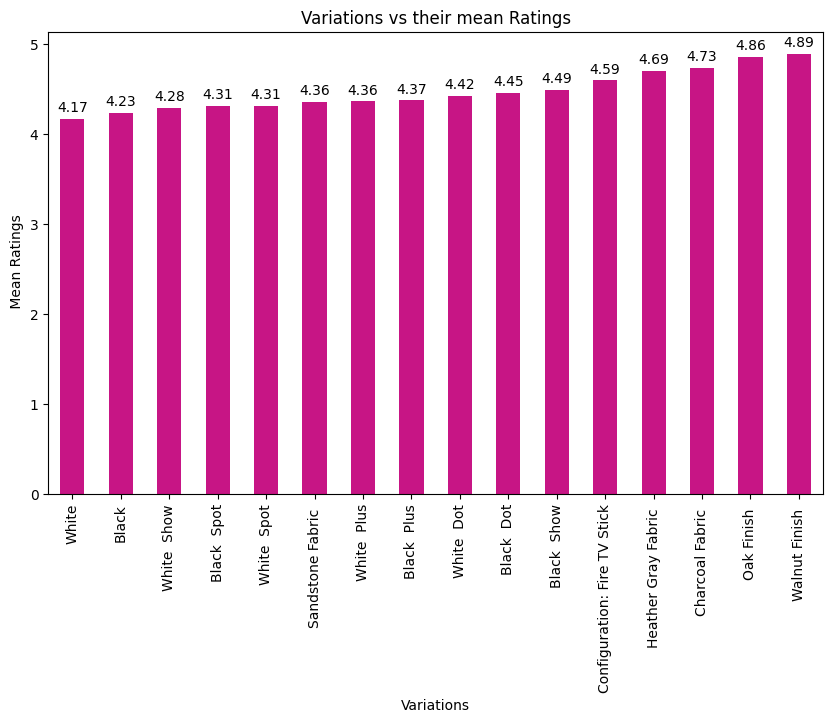

In [26]:
fig,ax = plt.subplots(figsize=(10,6))
ax = df.groupby('variation')['rating'].mean().sort_values(ascending=True).plot.bar(color= 'MediumVioletRed')

for i , value in enumerate(df.groupby('variation')['rating'].mean().sort_values(ascending=True).values):
  ax.text(i, value+0.05,str(round(value,2)),ha='center',va='bottom',fontsize=10)
plt.title("Variations vs their mean Ratings")
plt.xlabel("Variations")
plt.ylabel(" Mean Ratings")
plt.show()

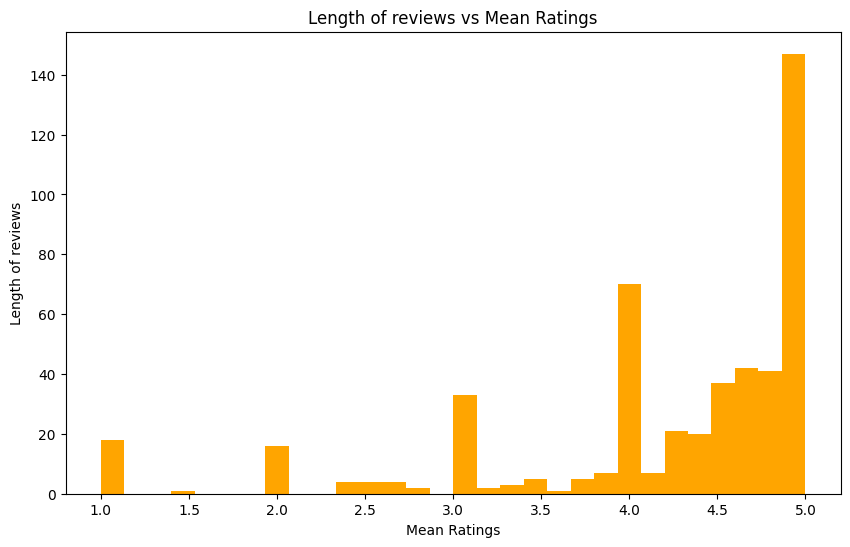

In [27]:
fig,ax = plt.subplots(figsize=(10,6))
df.groupby('length')['rating'].mean().sort_values().plot.hist(color='orange',bins=30)

plt.xlabel('Mean Ratings')
plt.ylabel('Length of reviews')
plt.title('Length of reviews vs Mean Ratings')
plt.show()

This graph shows us that if the reviews are long then they will most probably will be high rated and if the length of review is less and less rated

In [28]:
print(df.groupby('length')['rating'].mean().sort_values())

length
673     1.0
591     1.0
595     1.0
936     1.0
267     1.0
       ... 
380     5.0
381     5.0
129     5.0
357     5.0
2851    5.0
Name: rating, Length: 490, dtype: float64


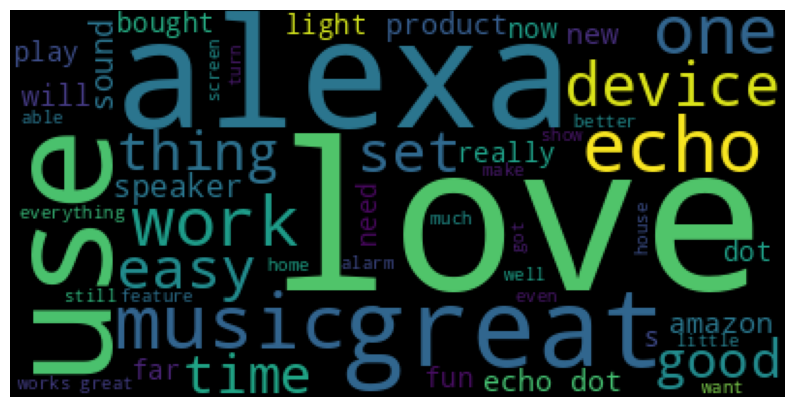

In [29]:
reviews  = " ".join([review for review in df['verified_reviews']]).lower()      # word cloud of reviews before removing stop words
wc = WordCloud(background_color='black',max_words=50)
wc.generate(reviews)
plt.figure(figsize=(10,6))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [30]:
print(STOPWORDS)

{'wasn', 'this', 'won', 'does', 'until', 'here', 'will', 'be', 'at', 'some', 'where', 'had', 'than', 'by', 'were', 'having', 'between', 'up', 'ours', 'an', 'he', 'under', 'them', 'same', 't', 'my', 'if', 'd', 'more', 'after', 'no', "mightn't", 'your', 'when', 'isn', 'his', 'weren', 'yourself', 'did', 'itself', 'into', 'against', 'own', "aren't", 'am', 'her', 'y', 'in', 'which', 'don', 'ourselves', 'why', 're', 'our', 've', "you're", 'to', "wouldn't", 'that', "she's", 'it', 'too', 'mustn', 'yourselves', 'with', 's', 'haven', 'have', "haven't", 'each', 'from', 'you', 'm', "you've", 'what', 'she', 'all', 'as', "shouldn't", 'been', 'few', 'further', "shan't", 'for', "should've", 'herself', 'again', 'a', 'through', 'hadn', "hadn't", 'off', "it's", 'down', 'how', 'i', 'didn', 'wouldn', 'once', "you'd", "needn't", "don't", 'was', 'the', 'is', "couldn't", "weren't", 'there', 'ain', 'just', "that'll", 'do', 'are', 'now', 'ma', 'needn', 'yours', "wasn't", 'should', 'themselves', 'such', 'both', 

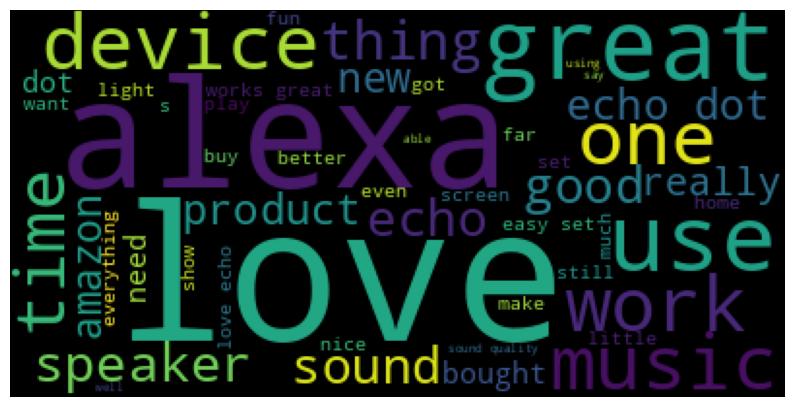

In [31]:
words = reviews.split()                                                         # word cloud of reviews before removing stop words
filtered_words = [word for word in words if word not in STOPWORDS]
filtered_reviews = " ".join(filtered_words)
wc.generate(filtered_reviews)
plt.figure(figsize=(10,6))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [32]:
neg_reviews = " ".join([review for review in df[df['feedback']==0]['verified_reviews']]).lower()
neg_words = neg_reviews.split()
neg_filtered_words = [word for word in neg_words if word not in STOPWORDS]

pos_reviews = " ".join([review for review in df[df['feedback']==1]['verified_reviews']]).lower()
pos_words = pos_reviews.split()
pos_filtered_words = [word for word in pos_words if word not in STOPWORDS]

unique_neg_words = [word for word in neg_filtered_words if word not in pos_filtered_words]
unique_pos_words = [word for word in pos_filtered_words if word not in neg_filtered_words]

unique_neg_reviews = " ".join([word for word in unique_neg_words])
unique_pos_reviews = " ".join([word for word in unique_pos_words])

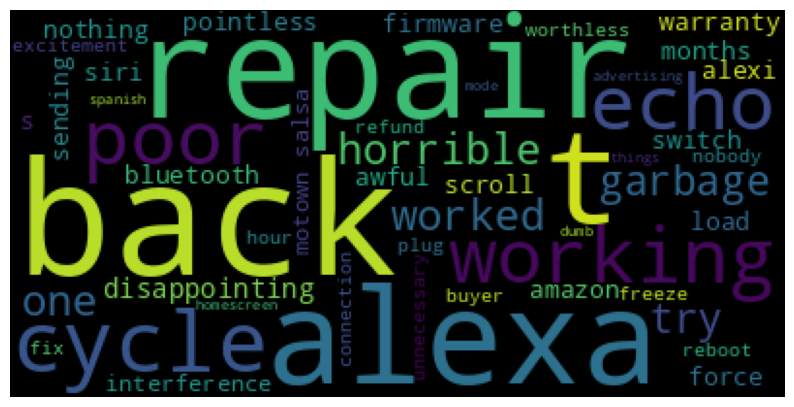

In [33]:
wc = WordCloud(background_color='black',max_words=50)
plt.figure(figsize=(10,6))
plt.imshow(wc.generate(unique_neg_reviews))
plt.axis("off")
plt.show()

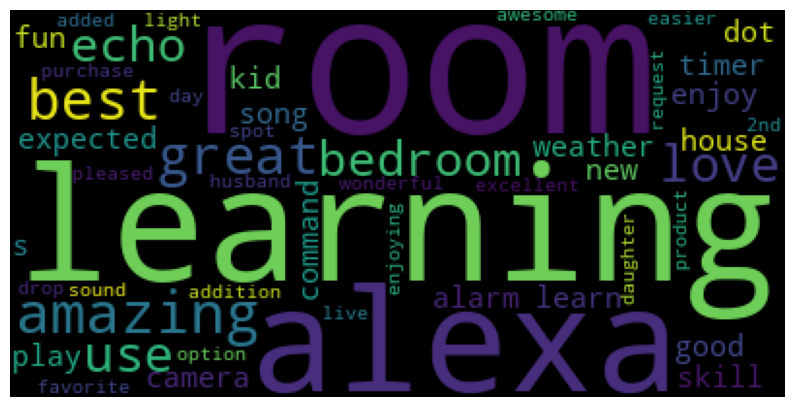

In [34]:
wc = WordCloud(background_color='black',max_words=50)
plt.figure(figsize=(10,6))
plt.imshow(wc.generate(unique_pos_reviews))
plt.axis("off")
plt.show()

# DATA PREPROCESSING and TRAINING , SELECTING suitable model



In [35]:
corpus=[]
stemmer = PorterStemmer()
for i in range(df.shape[0]):
  review = re.sub('[^a-zA-Z]'," ",df.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
  review = " ".join([word for word in review])
  corpus.append(review)

In [149]:
cv = CountVectorizer(max_features=2500)
x = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

#print(x)
#print(y)

In [150]:
print(x.shape)
print(y.shape)

(3149, 2500)
(3149,)


In [151]:
pickle.dump(cv,open('vectorizer.pkl','wb'))

In [80]:
df['feedback'].value_counts()

,count
feedback,
1,2893
0,256


In [152]:
smote = SMOTE(random_state = 42)
x, y= smote.fit_resample(x,y)

In [153]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4050, 2500)
(1736, 2500)
(4050,)
(1736,)


## **RANDOM FOREST CLASSIFIER**

In [154]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)

print("Training accuracy -:",rf.score(x_train,y_train))    # training and testing accuracy tells us about overfitting and underfitting
print("Testing accuracy -:",rf.score(x_test,y_test))

Training accuracy -: 0.9844444444444445
Testing accuracy -: 0.9377880184331797


In [155]:
y_predict = rf.predict(x_test)

print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))
print("accuracy score : ",rf.score(x_test,y_test))

[[807  42]
 [ 66 821]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       849
           1       0.95      0.93      0.94       887

    accuracy                           0.94      1736
   macro avg       0.94      0.94      0.94      1736
weighted avg       0.94      0.94      0.94      1736

accuracy score :  0.9377880184331797


### **Accuracy of model is -: 94%**

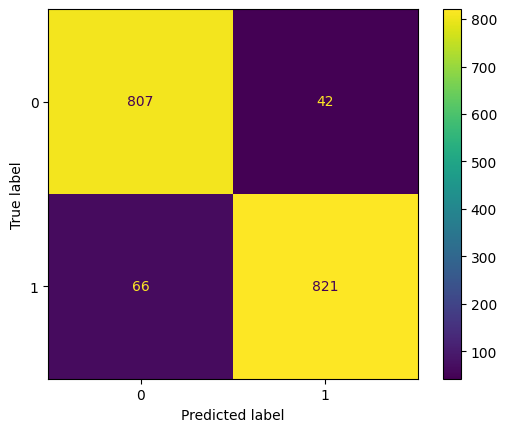

In [156]:
cm = confusion_matrix(y_test,y_predict)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= rf.classes_)
cm_display.plot()
plt.show()

In [94]:
params = {"bootstrap":[True], "max_depth": [80,100], "min_samples_split":[8,12], "n_estimators":[100,300] }
cv_obj = StratifiedKFold(n_splits=2)
gridsearch = GridSearchCV(estimator = rf , param_grid = params ,cv=cv_obj , verbose = 0)
gridsearch.fit(x_train,y_train.ravel())

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]})

In [95]:
print("Best Paramters are -:",gridsearch.best_params_)
print("Best Score is -:",gridsearch.best_score_)

Best Paramters are -: {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}
Best Score is -: 0.9212345679012346


## **XGBOOST**



In [96]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

print("Training accuracy -:",xgb.score(x_train,y_train))
print("Testing accuracy -:",xgb.score(x_test,y_test))

Training accuracy -: 0.9498765432098766
Testing accuracy -: 0.9124423963133641


In [98]:
y_predict = xgb.predict(x_test)

print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))
print("accuracy score : ",xgb.score(x_test,y_test))

[[819  30]
 [122 765]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       849
           1       0.96      0.86      0.91       887

    accuracy                           0.91      1736
   macro avg       0.92      0.91      0.91      1736
weighted avg       0.92      0.91      0.91      1736

accuracy score :  0.9124423963133641


### **Accuracy is -: 91%**

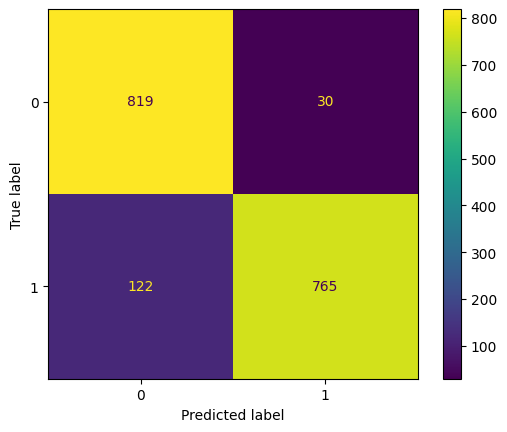

In [99]:
cm = confusion_matrix(y_test,y_predict)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= xgb.classes_)
cm_display.plot()

##**DECISION TREE CLASSIFIER**


In [167]:
dc = DecisionTreeClassifier(criterion='gini', max_depth= 100, random_state=42)

In [168]:
dc.fit(x_train,y_train)

print("Training accuracy -:",dc.score(x_train,y_train))
print("Testing accuracy -:",dc.score(x_test,y_test))

Training accuracy -: 0.9780246913580247
Testing accuracy -: 0.9193548387096774


In [169]:
y_pred = dc.predict(x_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("accuracy score : ",dc.score(x_test,y_test))

[[812  37]
 [103 784]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       849
           1       0.95      0.88      0.92       887

    accuracy                           0.92      1736
   macro avg       0.92      0.92      0.92      1736
weighted avg       0.92      0.92      0.92      1736

accuracy score :  0.9193548387096774


### **Accuracy is 92% with more overfitting than Random Forest and XGBoost**

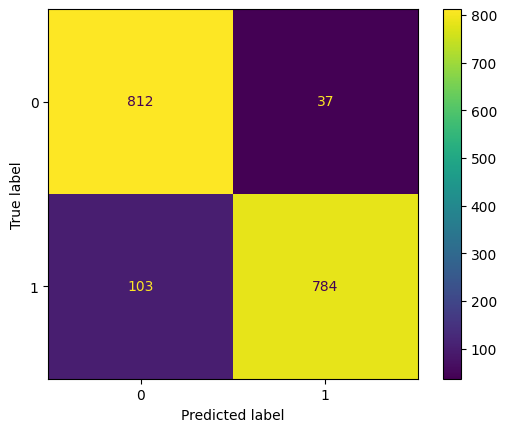

In [170]:
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= dc.classes_)
cm_display.plot()
plt.show()

# SAVING MODEL( RANDOM FOREST CLASSIFIER )

In [158]:
pickle.dump(rf,open('model.pkl','wb'))
print("Model saved!")

Model saved!


# TESTING OUR MODEL BY A USER

In [166]:
dc_model = pickle.load(open("model.pkl" , 'rb'))
c_v = pickle.load(open("vectorizer.pkl","rb"))

def preprocess_text(text):
  text = re.sub('[^a-zA-Z]',' ',text)
  text = text.lower().split()
  text = [word for word in text if word not in STOPWORDS]
  text = " ".join([word for word in text])
  return text

review = input("Enter your experience with your alexa :")
p_text = preprocess_text(review)
cv = CountVectorizer(max_features=2500)
vectorised_text = c_v.transform([p_text]).toarray()
pred = dc_model.predict(vectorised_text)
if(pred[0]==1):
  print("Your review is positive")
else:
  print("Your review is negative")

Enter your experience with your alexa :I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.
Your review is positive
